In [2]:
# import packages

import os
import sklearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression as sk_OLS
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import roc_auc_score

# import torch
# import torch.nn.functional as F
import math

from sklearn.metrics import r2_score
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression

In [3]:
import argparse
""" Training and hyperparameter search configurations """
curr_dir = os.getcwd()

parser = argparse.ArgumentParser(description='Midterm')
parser.add_argument('--seed', type=int, default=1,
                    help='random seed (default: 1)')
parser.add_argument('--glove_embeds_file', type=str, default=curr_dir +"\data\glove_embeds.npy", 
                    help='path to glove embeddings')
parser.add_argument('--glove_vocab_file', type=str,  default=curr_dir +"\data\glove_vocab.pkl",
                    help='path to glove vocab (same as args.glove_embeds_file if from original .txt)')
parser.add_argument('--glove_flag', type=bool, default=True, 
                    help='run method 1 (default: True)')
parser.add_argument('--glove_PCA_flag', type=bool, default=True, 
                    help='Run PCA, Plot PCA, nearest neighbors to check clustering GloVe (default: True)')
parser.add_argument('--knn_flag', type=bool, default=True, 
                    help='run ssl w/ knn for method 1a (default: True)')
parser.add_argument('--knn', type=int, default=5, 
                    help='number of nearest neighbors for method 1a (default: 40)')
parser.add_argument('--knn_full_gl_flag', type=bool, default=True, 
                    help='run ssl w/ knn for method for method 1b (default: False)')
parser.add_argument('--svc_flag', type=bool, default=True, 
                    help='run sklearn svc algo for method 1b (default: False)')
parser.add_argument('--ls_flag', type=bool, default=True, 
                    help='run sklearn ssl algo for method 1c (default: True)')
parser.add_argument('--stc_flag', type=bool, default=True, 
                    help='run sklearn stc algo for method 1c (default: False)')
parser.add_argument('--countvec_flag', type=bool, default=False, 
                    help='train (True) or load pre-saved processed data (False) (default: False)')
parser.add_argument('--knn_2_flag', type=bool, default=True, 
                    help='run ssl w/ knn for method 2a (default: True)')
parser.add_argument('--knn2', type=int, default=10, 
                    help='number of nearest neighbors for method 2a (default: 10)')
parser.add_argument('--knn_full_2_flag', type=bool, default=True, 
                    help='run knn to compute pseudolabels for method 2b (default: True)')
parser.add_argument('--ls2_flag', type=bool, default=True, 
                    help='run sklearn ssl algo for method 2c (default: True)')
parser.add_argument('--DBSCAN_flag', type=bool, default=True, 
                    help='run DBSCAN algo for method 2d (default: True)')
parser.add_argument('--DBSCAN_from_file_flag', type=bool, default=True, 
                    help='load dbscan from file if True, else recompute (default: True)')
parser.add_argument('--nn_plot_flag', type=bool, default=False, 
                    help='Run nearest neighbors if True, else load from file (default: False)')
parser.add_argument('--DBSCAN_plot_flag', type=bool, default=False, 
                    help='Run nearest neighbors and plot to determine EPS for DBSCAN for method 2d (default: True)')
parser.add_argument('--DBSCAN_plot_flag2', type=bool, default=True, 
                    help='Run PCA, Plot PCA, nearest neighbors to determine minimum sample in cluster for DBSCAN for method 2d (default: True)')
parser.add_argument('--ITPL_flag', type=bool, default=True, 
                    help='Iterative labeling with threshold for method 2e (default: True)')
parser.add_argument('--ITPL_from_file_flag', type=bool, default=True, 
                    help='Load best model from file (default: True)')
args = parser.parse_args("")

# Set random seed to reproduce results
np.random.seed(args.seed)

In [4]:
train_data = pd.read_csv(curr_dir + '\data\\raw_data\\train.csv')
val_data = pd.read_csv(curr_dir +'\data\\raw_data\\val.csv')
test_data = pd.read_csv(curr_dir +'\data\\raw_data\\test.csv')

# Preamble

### Visualize Data

In [5]:
# get all train data (labelled and unlabelled)
X_train    = train_data['Phrase']
y_train    = train_data['Sentiment']

# get only labelled training data
mask = (y_train != -100)
mask_dirty = (y_train == -100)
train_data_clean    = train_data[mask]
train_data_dirty    = train_data[mask_dirty]

X_train_clean    = X_train[mask]
y_train_clean    = y_train[mask]
X_train_dirty    = X_train[mask_dirty]
y_train_dirty    = y_train[mask_dirty]

# get val data
X_val    = val_data['Phrase']
y_val    = val_data['Sentiment']

# get test data
X_test     = test_data['Phrase']

# dataset shapes
X_train_len = X_train.shape[0]
X_train_clean_len = train_data_clean['Phrase'].shape[0]
X_val_len = X_val.shape[0]
X_text_len = X_test.shape[0]

print(f"Train Data Shape: {X_train.shape}")
print(f"Cleaned Train Data Shape: {train_data_clean['Phrase'].shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Test Data Shape: {X_test.shape}")

print(" ")
print(f"Number of labels = 0 in train dataset as percentage: {((y_train == 0).sum() / (X_train_len)) * 100:0.2f}%")
print(f"Number of labels = 1 in train dataset as percentage: {((y_train == 1).sum() / (X_train_len)) * 100:0.2f}%")
print(f"Number of labels = 2 in train dataset as percentage: {((y_train == 2).sum() / (X_train_len)) * 100:0.2f}%")
print(f"Number of labels = 3 in train dataset as percentage: {((y_train == 3).sum() / (X_train_len)) * 100:0.2f}%")
print(f"Number of labels = 4 in train dataset as percentage: {((y_train == 4).sum() / (X_train_len)) * 100:0.2f}%")
print(f"Number of labels = -100 in train dataset as percentage: {((y_train == -100).sum() / (X_train_len)) * 100:0.2f}%")

print(" ")
print(f"Number of labels = 0 in val dataset as percentage: {((y_val == 0).sum() / (X_val_len)) * 100:0.2f}%")
print(f"Number of labels = 1 in val dataset as percentage: {((y_val == 1).sum() / (X_val_len)) * 100:0.2f}%")
print(f"Number of labels = 2 in val dataset as percentage: {((y_val == 2).sum() / (X_val_len)) * 100:0.2f}%")
print(f"Number of labels = 3 in val dataset as percentage: {((y_val == 3).sum() / (X_val_len)) * 100:0.2f}%")
print(f"Number of labels = 4 in val dataset as percentage: {((y_val == 4).sum() / (X_val_len)) * 100:0.2f}%")
print(f"Number of labels = -100 in val dataset as percentage: {((y_val == -100).sum() / (X_val_len)) * 100:0.2f}%")

Train Data Shape: (109242,)
Cleaned Train Data Shape: (43697,)
Validation Data Shape: (23409,)
Test Data Shape: (23409,)
 
Number of labels = 0 in train dataset as percentage: 1.75%
Number of labels = 1 in train dataset as percentage: 6.91%
Number of labels = 2 in train dataset as percentage: 20.52%
Number of labels = 3 in train dataset as percentage: 8.46%
Number of labels = 4 in train dataset as percentage: 2.37%
Number of labels = -100 in train dataset as percentage: 60.00%
 
Number of labels = 0 in val dataset as percentage: 4.52%
Number of labels = 1 in val dataset as percentage: 17.47%
Number of labels = 2 in val dataset as percentage: 50.61%
Number of labels = 3 in val dataset as percentage: 21.33%
Number of labels = 4 in val dataset as percentage: 6.08%
Number of labels = -100 in val dataset as percentage: 0.00%


### Preproccesing Helpers

In [6]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    #added substitutions

    #***********added substitutions***********
    # remove all the special characters
    texter = re.sub(r'\W', ' ', texter)
    # remove all single characters
    texter = re.sub(r'\s+[a-zA-Z]\s+', ' ', texter)
    # Remove single characters from the start
    texter = re.sub(r'\^[a-zA-Z]\s+', ' ', texter)
    # Remove numbers
    texter = re.sub(r'\d+', ' ', texter)
    # Converting to Lowercase
    texter = texter.lower()
    # Remove punctuation
    texter = re.sub(r'[^\w\s]', ' ', texter)
    # Remove parentheses
    texter = re.sub(r'\([^)]*\)', ' ', texter)
    # Remove single quotes
    texter = re.sub(r'\'', ' ', texter)
    # Substituting multiple spaces with single space
    texter = re.sub(r'\s+', ' ', texter, flags=re.I)

    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

def clean_dataset(dataset):
    for row in range(dataset.shape[0]):
        dataset[row,0] = clean(dataset[row,0])
    return dataset

def tokenize_lexicon(texts):
    return_texts = []
    for i in range(len(texts)):
        return_texts.append(nltk.word_tokenize(texts[i]))
        return_texts[i] = nltk.pos_tag(return_texts[i])
    return return_texts

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wn.ADJ
    elif pos_tag.startswith('V'):
        return wn.VERB
    elif pos_tag.startswith('N'):
        return wn.NOUN
    elif pos_tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

def lemmatize_texts(texts):
    return_texts = []
    lemmer = nltk.stem.WordNetLemmatizer()
    for i in range(len(texts)):
        return_texts.append([])
        for j in range(len(texts[i])):
                return_texts[i].append(lemmer.lemmatize(texts[i][j][0], pos=get_wordnet_pos(texts[i][j][1])))
    return return_texts

def stem_texts(texts):
    return_texts = []
    ps = PorterStemmer()
    for i in range(len(texts)):
        return_texts.append([])
        for j in range(len(texts[i])):
                return_texts[i].append(ps.stem(texts[i][j][0]))
    return return_texts


def backtostring(texts):
    return_texts = []
    for i in range(len(texts)):
        return_texts.append(" ".join(texts[i]))
    return return_texts

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\valen\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\valen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\valen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Method 1: Approaches on GLoVe processed data
### (a) Variant 1
1. Pre-process by cleaning text, stemming/tokenizing, and removing stopwords
2. Embed using GLoVE to capture semantic meaning
3. Calculate sentence embeddings by averaging word embeddings
4. Use kNN on each labelled training data to conduct psuedo-labelling on unlabelled training data (based on the k chosen, since nearest neighbors chosen will not necessarily unique, we just add the first one. Now, a better algorithm would be one that chooses the label based on the smallest distance value, but we don't do that here. The distance metric for kNN evaluations is Euclidean distance.)
    - Tried many different $k$ values $k \in {5, 10, 25, 40, 50, 150, 300}$. Used 40 because it performed best
5. Use SGD on labelled dat, including pseudo-labelled data (don't use Multinomial NB regression bcuz X has negative values)

### GLoVE: Preprocessing

In [6]:
""" GLoVE Pre-processing Helper Functions """

import math
import sys
import pickle as pkl

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def glove_embedding():
    if ".txt" in args.glove_embeds_file:
        print("Enter txt")
        glove = {}
        with open("..\midterm\data\glove\glove.840B.300d.txt", 'rb') as f: # if 'r' fails with unicode error, please use 'rb'
            for line in f:
                values = line.split()
                word = values[0]
                word = word.decode('utf-8')
                vector = np.asarray(values[1:], "float32")
                glove[word] = vector
        glove_vocab = list(glove.keys())
        glove_embeds = np.array(list(glove.values()))
        np.save(curr_dir +"\data\\glove\\glove_embeds.npy", glove_embeds)
        with open(curr_dir + '\data\\glove\\glove_vocab.pkl', 'wb') as file:
            pkl.dump(glove_vocab, file)
    else:
        print("Enter pkl")
        with open(curr_dir + '\data\\glove\\glove_vocab.pkl', 'rb') as file:
            glove_vocab = pkl.load(file)
        glove_embeds = np.load(curr_dir +"\data\\glove\\glove_embeds.npy")
        glove = {v: arr for v, arr in zip(glove_vocab, glove_embeds)}
    return glove

def get_keywords_as_list(df):
    # Preprocess and get the keywords as a list of lists
    raw_list_keywords = []
    sentences = list(df["Phrase"])
    for sentence in sentences:
        # Each entry in "keywords" is a list of keywords. But they are stored as strings and not as a list.
        # We need to convert this string to a list.
        sentence = sentence.lower()
        sentence = re.sub(r'\'', '', sentence)
        sentence = sentence.replace("-", " ")
        tokens = nltk.word_tokenize(sentence)
        filtered_tokens = [word for word in tokens if word not in stop_words and len(word)!=1]
        raw_list_keywords.append(filtered_tokens)
    return raw_list_keywords

def clean_list_keywords(raw_lkeys, glove):
    cleaned_list_keywords = []
    for lkeys in raw_lkeys:
        cleaned_list_keywords.append([key for key in lkeys if key in glove.keys()])
    return cleaned_list_keywords 

def get_feature_list(cleaned_lkeys, glove, glove_dim=300):
    feat_list = []
    for lkeys in cleaned_lkeys:
        # Sentence value = avg. embeds of its words
        rep_glove_vec = np.zeros(glove_dim)
        if lkeys:
            for key in lkeys:
                rep_glove_vec += glove[key]
            rep_glove_vec /= len(lkeys)
        feat_list.append(rep_glove_vec)
    return np.array(feat_list)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\valen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
if args.glove_flag:
    glove = glove_embedding()
    print(len(glove.keys()))  # Size of glove vocab

Enter pkl
2196017


In [8]:
if args.glove_flag:
    train_kws = clean_list_keywords(get_keywords_as_list(train_data_clean), glove)
    train_dirty_kws = clean_list_keywords(get_keywords_as_list(train_data_dirty), glove)
    val_kws = clean_list_keywords(get_keywords_as_list(val_data), glove)
    test_kws = clean_list_keywords(get_keywords_as_list(test_data), glove)

In [9]:
if args.glove_flag:
    X_train_gl = get_feature_list(train_kws, glove)
    X_train_ulbd_gl = get_feature_list(train_dirty_kws, glove)
    X_val_gl = get_feature_list(val_kws, glove)
    X_test_gl = get_feature_list(test_kws, glove)

#### Baseline SGD (Clean Data)

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

if args.knn_flag:
    clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42)
    clf_sgd.fit(X_train_gl, y_train_clean)
    y_val_pred = clf_sgd.predict(X_val_gl)
    print('Accuracy: ', accuracy_score(y_val, y_val_pred))
    print(f"Number of labels = 0 in val dataset as percentage: {((y_val_pred == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 1 in val dataset as percentage: {((y_val_pred == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 2 in val dataset as percentage: {((y_val_pred == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 3 in val dataset as percentage: {((y_val_pred == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 4 in val dataset as percentage: {((y_val_pred == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Accuracy:  0.4934854115938314
Number of labels = 0 in val dataset as percentage: 1.71%
Number of labels = 1 in val dataset as percentage: 22.50%
Number of labels = 2 in val dataset as percentage: 41.99%
Number of labels = 3 in val dataset as percentage: 33.20%
Number of labels = 4 in val dataset as percentage: 0.59%


Conduct PCA on 2 components to check clusters

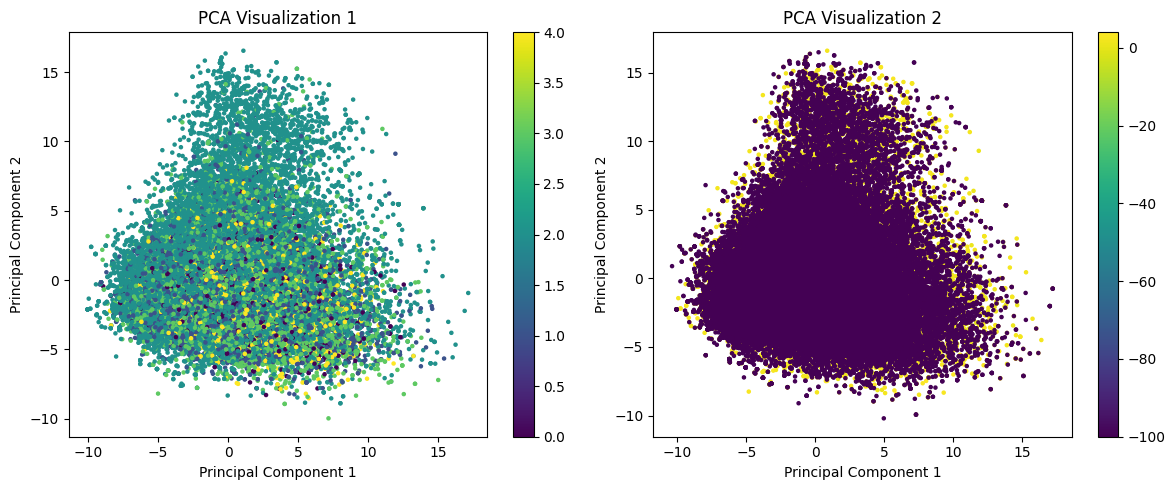

In [11]:
if args.glove_flag and args.glove_PCA_flag:
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    # Combine the labeled and unlabeled data
    # X_combined = np.vstack((X_train_2, X_train_dirty_2))
    scaler = StandardScaler()
    X_standardized_gl = scaler.fit_transform(X_train_gl)

    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(X_standardized_gl)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # First PCA Visualization
    sc1 = axs[0].scatter(principal_components[:, 0], principal_components[:, 1], c=np.array(y_train_clean), s=5)
    cbar1 = plt.colorbar(sc1, ax=axs[0])
    axs[0].set_xlabel('Principal Component 1')
    axs[0].set_ylabel('Principal Component 2')
    axs[0].set_title('PCA Visualization 1')

    scaler = StandardScaler()
    X_combined_gl = np.vstack((X_train_gl, X_train_ulbd_gl))
    y_combined = np.concatenate([np.array(y_train_clean), np.array(y_train_dirty)])
    X_standardized2_gl = scaler.fit_transform(X_combined_gl)
    pca2 = PCA(n_components=2)
    principal_components2 = pca.fit_transform(X_standardized2_gl)

    # Second PCA Visualization
    sc2 = axs[1].scatter(principal_components2[:, 0], principal_components2[:, 1], c=y_combined, s=5)
    cbar2 = plt.colorbar(sc2, ax=axs[1])
    axs[1].set_xlabel('Principal Component 1')
    axs[1].set_ylabel('Principal Component 2')
    axs[1].set_title('PCA Visualization 2')

    plt.tight_layout()
    plt.show()


Although the base SGD accuracy value with GlOVE is lower than baseline SGD with unigrams, the clustering appears to better, so a kNN approach may be beneficial.

### Pseudo-labelling: Add kNN with smallest distance to training set

In [12]:
from sklearn.neighbors import NearestNeighbors

if args.knn_flag:
    knn_idxs_len = 0

    neigh = NearestNeighbors(n_neighbors=args.knn)
    neigh.fit(X_train_ulbd_gl)
    knn_idxs = neigh.kneighbors(X_train_gl, return_distance=False)
    knn_idxs_unique = np.unique(knn_idxs.ravel())
    knn_idxs_len = knn_idxs_unique.shape[0]

    print(knn_idxs.shape)

(43697, 5)


In [13]:
if args.knn_flag:
    knn_idxs_lst = knn_idxs.tolist()
    seen = set()
    n_clean_data = train_data_clean.shape[0]
    print(n_clean_data)

    X_train_new_clean_np = []
    y_train_new_clean_np = []
    y_train_clean_np = np.array(y_train_clean)
    y_train_dirty_np = np.array(y_train_dirty)
    idx = 0
    for col in range(args.knn):
        for row in range(n_clean_data):
            x_ulbd_idx = knn_idxs_lst[row][col]
            if x_ulbd_idx not in seen:
                seen.add(x_ulbd_idx)
                # Add the closest neighbor "dirty" vector
                X_train_new_clean_np.append(X_train_ulbd_gl[x_ulbd_idx])
                # Get the y_lab corresponding to the rowth vector of X_train_clean
                y_lab = y_train_clean_np[row]
                y_train_new_clean_np.append(y_lab)

    X_train_new_clean_np = np.array(X_train_new_clean_np)
    y_train_new_clean_np = np.array(y_train_new_clean_np)

43697


In [14]:
if args.knn_flag:
    X_train_new_np = np.concatenate([X_train_gl, X_train_new_clean_np], axis=0)
    y_train_new_np = np.concatenate([y_train_clean_np, y_train_new_clean_np], axis=0)

#### SGD (Clean + Partially PseudoLabelled Data)

In [15]:
# X_val_np = np.array()
if args.knn_flag:
    clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42)
    clf_sgd.fit(X_train_new_np, y_train_new_np)
    y_val_pred = clf_sgd.predict(X_val_gl)
    y_test_pred = clf_sgd.predict(X_test_gl)
    # print("Feature Count \n",clf_sgd.feature_count_)
    # print("Class Log Prior ",clf_sgd.class_log_prior_)
    print('Accuracy: ', accuracy_score(y_val, y_val_pred))
    # print(clf_sgd.predict_proba(X_test))
    print(f"Number of labels = 0 in val dataset as percentage: {((y_val_pred == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 1 in val dataset as percentage: {((y_val_pred == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 2 in val dataset as percentage: {((y_val_pred == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 3 in val dataset as percentage: {((y_val_pred == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 4 in val dataset as percentage: {((y_val_pred == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Accuracy:  0.544320560468196
Number of labels = 0 in val dataset as percentage: 0.01%
Number of labels = 1 in val dataset as percentage: 4.24%
Number of labels = 2 in val dataset as percentage: 84.10%
Number of labels = 3 in val dataset as percentage: 11.12%
Number of labels = 4 in val dataset as percentage: 0.52%


### (b) Variant 2
1. Pre-process by cleaning text, stemming/tokenizing, and removing stopwords
2. Embed using GLoVE to capture semantic meaning
3. Calculate sentence embeddings by averaging word embeddings
4. Conduct pseudo-labelling through knn on entire dataset
5. SGD supervised learning

In [16]:
if args.knn_full_gl_flag:
    from sklearn.neighbors import KNeighborsClassifier

    X_kmeans_gl = X_train_gl.copy()
    y_kmeans_gl = y_train_clean_np.copy()
    X_ulbd_kmeans_gl = X_train_ulbd_gl.copy()
    knc = KNeighborsClassifier(n_neighbors=args.knn, weights='distance', n_jobs=-1)
    knc.fit(X_kmeans_gl, y_kmeans_gl)

    # Get cluster centers and labels
    y_ulbd_pred_kmeans_gl = knc.predict(X_ulbd_kmeans_gl)
    X_train_new_kmeans_np = np.concatenate([X_kmeans_gl, X_ulbd_kmeans_gl])
    y_train_new_kmeans_np = np.concatenate([y_kmeans_gl, y_ulbd_pred_kmeans_gl])

In [17]:
if args.knn_full_gl_flag:
    clf_sgd = SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-5, random_state=42)
    clf_sgd.fit(X_train_new_kmeans_np, y_train_new_kmeans_np)
    y_val_kmeans_pred_gl = clf_sgd.predict(X_val_gl)
    # y_test_kmeans_pred_gl = clf_sgd.predict(X_test_gl)
    # print("Feature Count \n",clf_sgd.feature_count_)
    # print("Class Log Prior ",clf_sgd.class_log_prior_)
    print('Accuracy: ', accuracy_score(y_val, y_val_kmeans_pred_gl))
    # print(clf_sgd.predict_proba(X_test))
    print(f"Number of labels = 0 in val dataset as percentage: {((y_val_kmeans_pred_gl == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 1 in val dataset as percentage: {((y_val_kmeans_pred_gl == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 2 in val dataset as percentage: {((y_val_kmeans_pred_gl == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 3 in val dataset as percentage: {((y_val_kmeans_pred_gl == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 4 in val dataset as percentage: {((y_val_kmeans_pred_gl == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Accuracy:  0.5085223631936435
Number of labels = 0 in val dataset as percentage: 0.73%
Number of labels = 1 in val dataset as percentage: 14.69%
Number of labels = 2 in val dataset as percentage: 56.36%
Number of labels = 3 in val dataset as percentage: 22.69%
Number of labels = 4 in val dataset as percentage: 5.54%


### Summary:
- SGD on GloVe embeddings trained worse than baseline CountVectorizer and BoW pre-processing methods 

### (c) Variant 3
1. Pre-process by cleaning text, stemming/tokenizing, and removing stopwords
2. Embed using GloVe to capture semantic meaning
3. Calculate sentence embeddings by averaging word embeddings
4. Semi-supervised learning method
    - Replace -100 with -1
    - Use sklearn's LabelSpreading, designed for this purpose, with kernel = 'knn' because 'rbf' takes too much memory 

#### LabelSpreading

In [18]:
if args.ls_flag:
    # fit
    X_train_ls = np.concatenate([X_train_gl, X_train_ulbd_gl])
    y_train_clean_np = np.array(y_train_clean_np)
    y_train_dirty_np = np.zeros_like(y_train_dirty) -1
    y_train_ls = np.concatenate([y_train_clean_np, y_train_dirty_np])
    ls50 = LabelSpreading(kernel = 'knn').fit(X_train_ls, y_train_ls)

    # predict/ pseudo-labelling
    y_val_pred_ls = ls50.predict(X_val_gl)
    print('Accuracy: ', accuracy_score(y_val, y_val_pred_ls))

    # check label distribution
    print(f"Number of labels = 0 in val dataset as percentage: {((y_val_pred_ls == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 1 in val dataset as percentage: {((y_val_pred_ls == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 2 in val dataset as percentage: {((y_val_pred_ls == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 3 in val dataset as percentage: {((y_val_pred_ls == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 4 in val dataset as percentage: {((y_val_pred_ls == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Accuracy:  0.5347943098808151
Number of labels = 0 in val dataset as percentage: 4.80%
Number of labels = 1 in val dataset as percentage: 18.11%
Number of labels = 2 in val dataset as percentage: 47.92%
Number of labels = 3 in val dataset as percentage: 22.53%
Number of labels = 4 in val dataset as percentage: 6.64%


c:\Users\valen\anaconda3\envs\nlp-m\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:227: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Summary: (a) yields 0.54432 as compared to (b) 0.53479.

## Method 2: Approaches on Unigram processed data

### Preprocess the data using CountVectorizer, nltk stem

In [7]:
if args.countvec_flag:
    lemma = True

    # train set
    train = clean_dataset(np.array(train_data_clean))
    train_dirty = clean_dataset(np.array(train_data_dirty))
    val = clean_dataset(np.array(val_data))
    test = clean_dataset(np.expand_dims(np.array(test_data["Phrase"]), axis = 1))
    print(train[:,0].shape)
    print(train_dirty[:,0].shape)
    print(val[:,0].shape)
    print(test[:,0].shape)
    print(np.concatenate((train[:,0], train_dirty[:,0], test[:,0], val[:,0])).shape)

    token_texts = tokenize_lexicon(np.concatenate((train[:,0], train_dirty[:,0], val[:,0], test[:,0])))

    del train
    # del train_dirty
    del val
    del test

    if(lemma):
        lemm_texts = lemmatize_texts(token_texts)
    else:
        lemm_texts = stem_texts(token_texts)
    del token_texts
    processed_texts = backtostring(lemm_texts)
    del lemm_texts

    # matrix counts
    vectorizer = CountVectorizer(input='content', stop_words='english', min_df=10, max_features = 5000)
    X = vectorizer.fit_transform(processed_texts)
    del processed_texts
    del vectorizer
    X_dense = X.todense()
    print(X_dense.shape)
    del X

    # tfidf
    tfidf_vectorizer = TfidfTransformer()
    X_tfidf = tfidf_vectorizer.fit_transform(np.array(X_dense))
    del X_dense
    X_data = (np.array(X_tfidf.todense()))
    print("X_data.shape: ", X_data.shape)
    X_train_2 = X_data[:train_data_clean['Phrase'].shape[0]]
    X_train_dirty_2 = X_data[train_data_clean['Phrase'].shape[0]:train_data_clean['Phrase'].shape[0]+train_data_dirty['Phrase'].shape[0]]
    X_val_2 = X_data[train_data_clean['Phrase'].shape[0]+train_data_dirty['Phrase'].shape[0]: train_data_clean['Phrase'].shape[0]+train_data_dirty['Phrase'].shape[0]+ val_data['Phrase'].shape[0]]
    X_test_2 = X_data[train_data_clean['Phrase'].shape[0]+train_data_dirty['Phrase'].shape[0]+ val_data['Phrase'].shape[0]:]
    del X_data
    print("X_train.shape: ", X_train.shape)
    print("X_train_dirty.shape", X_train_dirty_2.shape)
    print("X_val.shape: ", X_val.shape)
    print("X_test.shape: ", X_test.shape)


    # Save for easy loading
    np.save(curr_dir +"\data\X_train_2.npy", X_train_2)
    np.save(curr_dir +"\data\X_train_dirty_2.npy", X_train_dirty_2)
    np.save(curr_dir +"\data\X_val_2.npy", X_val_2)
    np.save(curr_dir +"\data\X_test_2.npy", X_test_2)

In [8]:
if not args.countvec_flag:
    X_train_2 = np.load(curr_dir +"\data\\unigram\\X_train_2.npy")
    X_train_dirty_2 = np.load(curr_dir +"\data\\unigram\\X_train_dirty_2.npy")
    X_val_2 = np.load(curr_dir +"\data\\unigram\\X_val_2.npy")
    X_test_2 = np.load(curr_dir +"\data\\unigram\\X_test_2.npy")

####  SGD Baseline

(i) Baseline from original template with hinge loss

In [21]:
if args.knn_full_2_flag:
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import accuracy_score

    clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42, n_jobs=-1)
    clf_sgd.fit(X_train_2, y_train_clean)
    y_val_pred = clf_sgd.predict(X_val_2)
    # y_test_pred = clf_sgd.predict(X_test_2)
    print('Accuracy: ', accuracy_score(y_val, y_val_pred))

Accuracy:  0.5887479174676407


(ii) Baseline with modified_huber loss

In [22]:
if args.knn_full_2_flag:
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import accuracy_score

    clf_sgd = SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-5, random_state=42, n_jobs=-1)
    clf_sgd.fit(X_train_2, y_train_clean)
    y_val_pred = clf_sgd.predict(X_val_2)
    # y_test_pred = clf_sgd.predict(X_test_2)
    print('Accuracy: ', accuracy_score(y_val, y_val_pred))

Accuracy:  0.5904139433551199


### (a) Variant 1: Partial Pseudo-labelling--Add kNN with smallest distance to training set
1. Pre-process by cleaning text, stemming/tokenizing, and removing stopwords
2. CountVectorizer (5000, 7000)
3. Find k nearest neighbors of a given labelled point from the unlabelled part of the dataset to conduct pseudolabelling, adding only the unique points to the concatenated training data set
    - Specify the k value in argsparse
    - Note that depending on the k value, there will not be
    - Euclidean distance captures measuring number of words in common
4. Use SGD on labelled dat, including pseudo-labelled data (don't use Multinomial NB regression bcuz X has negative values)


In [23]:
from sklearn.neighbors import NearestNeighbors
if args.knn_2_flag:
    knn_idxs_len = 0

    neigh = NearestNeighbors(n_neighbors=args.knn2, n_jobs=-1)
    neigh.fit(X_train_dirty_2)
    knn_idxs_2 = neigh.kneighbors(X_train_2, return_distance=False)
    knn_idxs_unique_2 = np.unique(knn_idxs_2.ravel())
    knn_idxs_len_2 = knn_idxs_unique_2.shape[0]

    print(knn_idxs_2.shape)
    knn_idxs_lst = knn_idxs_2.tolist()
    n_clean_data = train_data_clean.shape[0]
    print(n_clean_data)

(43697, 10)
43697


In [24]:
if args.knn_2_flag:    
    seen = set()
    X_train_new_clean_np_2 = []
    y_train_new_clean_np_2 = []
    y_train_clean_np_2 = np.array(y_train_clean)
    y_train_dirty_np_2 = np.array(y_train_dirty)
    idx = 0
    for col in range(args.knn2):
        for row in range(n_clean_data):
            x_ulbd_idx = knn_idxs_lst[row][col]
            if x_ulbd_idx not in seen:
                seen.add(x_ulbd_idx)
                # Add the closest neighbor "dirty" vector
                X_train_new_clean_np_2.append(X_train_dirty_2[x_ulbd_idx])
                # Get the y_lab corresponding to the rowth vector of X_train_clean
                y_lab = y_train_clean_np_2[row]
                y_train_new_clean_np_2.append(y_lab)

    X_train_new_clean_np_2 = np.array(X_train_new_clean_np_2)
    y_train_new_clean_np_2 = np.array(y_train_new_clean_np_2)

    X_train_new_np = np.concatenate([X_train_2, X_train_new_clean_np_2], axis=0)
    y_train_new_np = np.concatenate([y_train_clean_np_2, y_train_new_clean_np_2], axis=0)

#### SGD Classifier (knn)

In [25]:
if args.knn_2_flag:
    clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42, n_jobs=-1)
    clf_sgd.fit(X_train_new_np, y_train_new_np)

    y_val_knn_pred_2 = clf_sgd.predict(X_val_2)
    y_test_knn_pred_2 = clf_sgd.predict(X_test_2)
    # print("Feature Count \n",clf_sgd.feature_count_)
    # print("Class Log Prior ",clf_sgd.class_log_prior_)
    print('Accuracy: ', accuracy_score(y_val, y_val_knn_pred_2))
    # print(clf_sgd.predict_proba(X_test))

Accuracy:  0.5829809047802127


In [26]:
if args.knn_2_flag:
    print(y_val_knn_pred_2)
    print('Accuracy: ', accuracy_score(y_val, y_val_knn_pred_2))
    print(f"Number of labels = 0 in val dataset as percentage: {((y_val_knn_pred_2 == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 1 in val dataset as percentage: {((y_val_knn_pred_2 == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 2 in val dataset as percentage: {((y_val_knn_pred_2 == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 3 in val dataset as percentage: {((y_val_knn_pred_2 == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 4 in val dataset as percentage: {((y_val_knn_pred_2 == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

[0 0 3 ... 2 2 4]
Accuracy:  0.5829809047802127
Number of labels = 0 in val dataset as percentage: 2.80%
Number of labels = 1 in val dataset as percentage: 9.43%
Number of labels = 2 in val dataset as percentage: 66.65%
Number of labels = 3 in val dataset as percentage: 17.79%
Number of labels = 4 in val dataset as percentage: 3.33%


### (b) Variant 2: Complete Pseudo-labelling w/ kNN
1. Pre-process by cleaning text, stemming/tokenizing, and removing stopwords
2. CountVectorizer (5000, 7000)
4. Use built-in knn on entire dataset to conduct pseudolabelling
5. Use SGD on labelled dat, including pseudo-labelled data (don't use Multinomial NB regression bcuz X has negative values)

### KNeighborsClassifier + PseudoLabelling

In [27]:
if args.knn_full_2_flag:
    X_kmeans_2 = X_train_2.copy()
    y_kmeans_2 = y_train_clean_np.copy()
    X_ulbd_kmeans_2 = X_train_dirty_2.copy()
    y_ulbd_pred_kmeans_2 = y_train_dirty_np.copy()

In [28]:
if args.knn_full_2_flag:
    import numpy as np
    from sklearn.neighbors import KNeighborsClassifier
    knc = KNeighborsClassifier(n_neighbors=args.knn, weights='distance', n_jobs=-1)
    knc.fit(X_kmeans_2, y_kmeans_2)

In [29]:
if args.knn_full_2_flag:
    y_ulbd_pred_kmeans_2 = knc.predict(X_ulbd_kmeans_2)
    X_train_new_kmeans_np_2 = np.concatenate([X_kmeans_2, X_ulbd_kmeans_2])
    y_train_new_kmeans_np_2 = np.concatenate([y_kmeans_2, y_ulbd_pred_kmeans_2])

#### SGD Classifier (knn built-in to label entire unlabelled dataset)

In [30]:
if args.knn_full_2_flag:
    clf_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=42)
    clf_sgd.fit(X_train_new_kmeans_np_2, y_train_new_kmeans_np_2)

    y_val_kmeans_pred_2 = clf_sgd.predict(X_val_2)
    # y_test_kmeans_pred_2 = clf_sgd.predict(X_test_2)
    print('Accuracy: ', accuracy_score(y_val, y_val_kmeans_pred_2))

Accuracy:  0.5734119355803323


In [31]:
if args.knn_full_2_flag:
    print(y_val_kmeans_pred_2)
    print('Accuracy: ', accuracy_score(y_val, y_val_kmeans_pred_2))
    print(f"Number of labels = 0 in val dataset as percentage: {((y_val_kmeans_pred_2 == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 1 in val dataset as percentage: {((y_val_kmeans_pred_2 == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 2 in val dataset as percentage: {((y_val_kmeans_pred_2 == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 3 in val dataset as percentage: {((y_val_kmeans_pred_2 == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 4 in val dataset as percentage: {((y_val_kmeans_pred_2 == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

[0 0 2 ... 3 2 4]
Accuracy:  0.5734119355803323
Number of labels = 0 in val dataset as percentage: 1.79%
Number of labels = 1 in val dataset as percentage: 8.82%
Number of labels = 2 in val dataset as percentage: 72.47%
Number of labels = 3 in val dataset as percentage: 14.26%
Number of labels = 4 in val dataset as percentage: 2.65%


#### (c) Variant 3: LabelSpreading w/ knn


In [32]:
if args.ls2_flag:
    # fit
    X_train_ls2 = np.concatenate([X_train_2, X_train_dirty_2])
    y_train_clean_np = np.array(y_train_clean)
    y_train_dirty_np = np.zeros_like(y_train_dirty) -1
    y_train_ls2 = np.concatenate([y_train_clean_np, y_train_dirty_np])
    ls50 = LabelSpreading(kernel = 'knn', n_jobs=-1).fit(X_train_ls2, y_train_ls2)

    # predict/ pseudo-labelling
    y_val_pred_ls2 = ls50.predict(X_val_2)
    print('Accuracy: ', accuracy_score(y_val, y_val_pred_ls2))

    # check label distribution
    print(f"Number of labels = 0 in val dataset as percentage: {((y_val_pred_ls2 == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 1 in val dataset as percentage: {((y_val_pred_ls2 == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 2 in val dataset as percentage: {((y_val_pred_ls2 == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 3 in val dataset as percentage: {((y_val_pred_ls2 == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 4 in val dataset as percentage: {((y_val_pred_ls2 == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Accuracy:  0.560724507667991
Number of labels = 0 in val dataset as percentage: 2.77%
Number of labels = 1 in val dataset as percentage: 12.34%
Number of labels = 2 in val dataset as percentage: 65.55%
Number of labels = 3 in val dataset as percentage: 15.78%
Number of labels = 4 in val dataset as percentage: 3.57%


c:\Users\valen\anaconda3\envs\nlp-m\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:227: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


#### (d) Variant 4: DBSCAN Clustering
1. Pre-process by cleaning text, stemming/tokenizing, and removing stopwords
2. CountVectorizer (5000, 7000)
3. Use built-in unsupervised learning method DBSCAN on entire dataset to conduct pseudolabelling
4. Use SGD, Multinomial NB regression on labelled dat, including pseudo-labelled data
    - Doubtful that MNB will be any good because it is highly sensitive to mode

- Plot nearest neighbors distances
- Choose `eps` based on point where graph shows steepest ascent.

In [33]:
if args.DBSCAN_flag and args.nn_plot_flag:
    from sklearn.neighbors import NearestNeighbors
    import matplotlib.pyplot as plt

    # Combine the labeled and unlabeled data
    X_combined = np.vstack((X_train_2, X_train_dirty_2))

    neigh = NearestNeighbors(n_neighbors=5, n_jobs=-1)
    nbrs = neigh.fit(X_combined)  # X is your dataset
    distances, indices = nbrs.kneighbors(X_combined)
    distances = sorted(distances[:, 4], reverse=True)
    np.save(curr_dir + '\data\\unigram\\pca_knn_sorted_distances', distances)

In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(curr_dir + '/figs//mpl_styles//ieee.mplstyle')

if args.DBSCAN_flag and args.DBSCAN_plot_flag and not args.nn_plot_flag:    
    # Sort distance values by ascending order and plot
    distances = np.load(curr_dir + '\data\\unigram\\pca_knn_sorted_distances.npy')
    plt.plot(distances)
    plt.title('Nearest Neighbor Distance')
    plt.xlabel('Sorted Datapoints')
    plt.ylabel(r'$\epsilon$' + ' values')
    plt.savefig(curr_dir + r"\figs\\knn_sorted_distances.png", bbox_inches='tight', dpi=400)
    plt.show()

Conduct PCA/TSNE to visualize clusters in 2D

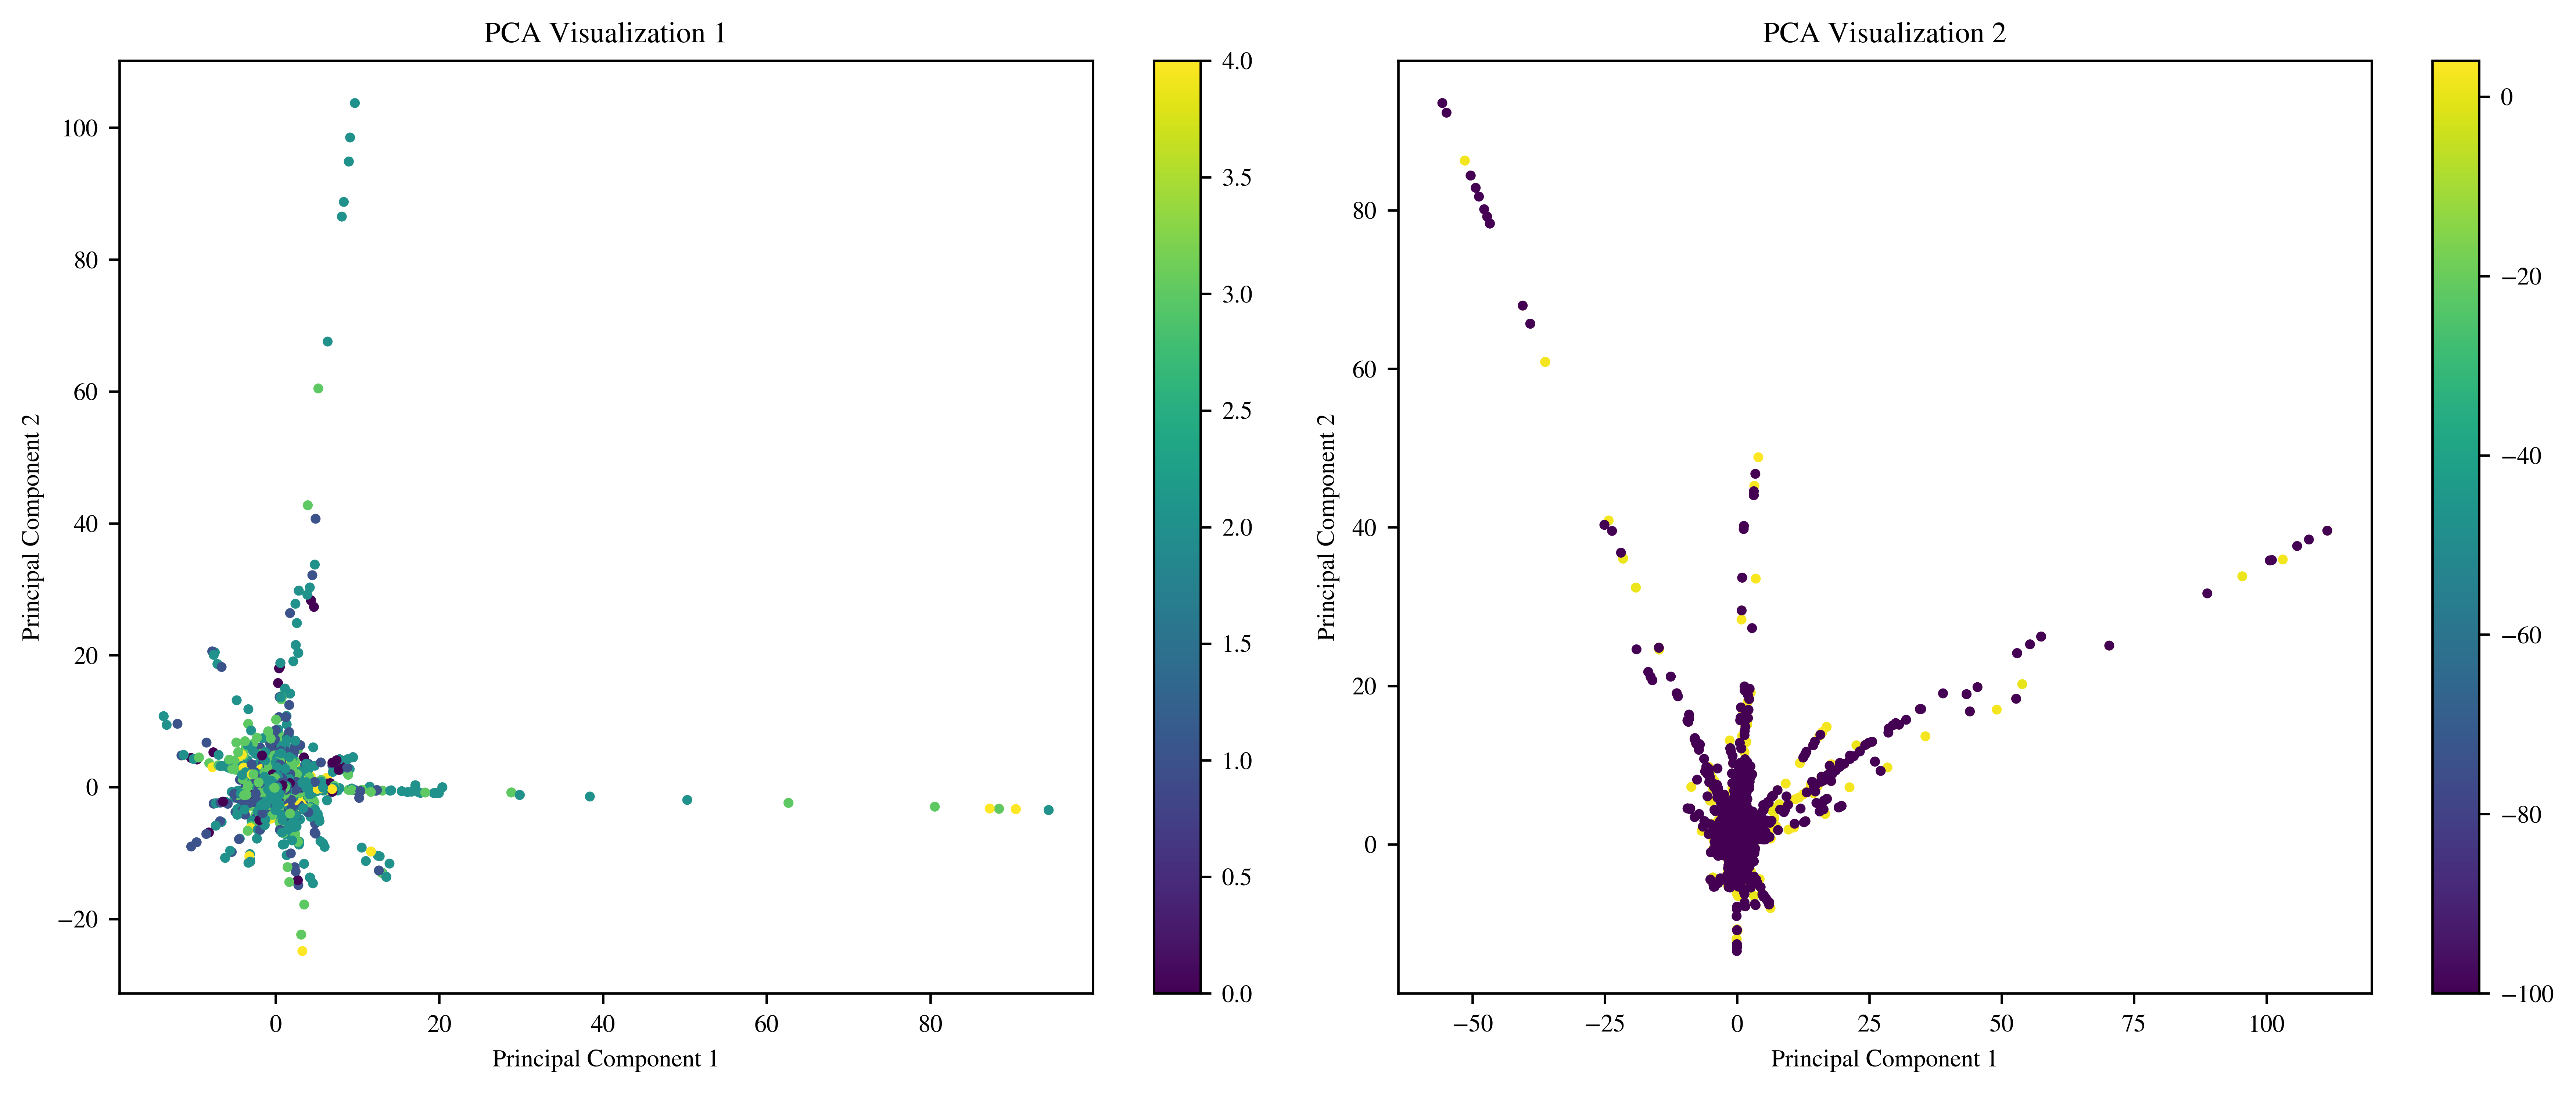

In [35]:
if args.DBSCAN_flag and args.DBSCAN_plot_flag2:
    from sklearn.preprocessing import StandardScaler
    from sklearn.neighbors import NearestNeighbors
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    # Combine the labeled and unlabeled data
    # X_combined = np.vstack((X_train_2, X_train_dirty_2))
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X_train_2)

    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_standardized)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # First PCA Visualization
    sc1 = axs[0].scatter(principal_components[:, 0], principal_components[:, 1], c=np.array(y_train_clean), s=5)
    cbar1 = plt.colorbar(sc1, ax=axs[0])
    axs[0].set_xlabel('Principal Component 1')
    axs[0].set_ylabel('Principal Component 2')
    axs[0].set_title('PCA Visualization 1')

    scaler = StandardScaler()
    X_combined = np.vstack((X_train_2, X_train_dirty_2))
    y_combined = np.concatenate([np.array(y_train_clean), np.array(y_train_dirty)])
    X_standardized2 = scaler.fit_transform(X_combined)
    pca2 = PCA(n_components=2)
    principal_components2 = pca.fit_transform(X_standardized2)

    # Second PCA Visualization
    sc2 = axs[1].scatter(principal_components2[:, 0], principal_components2[:, 1], c=y_combined, s=5)
    cbar2 = plt.colorbar(sc2, ax=axs[1])
    axs[1].set_xlabel('Principal Component 1')
    axs[1].set_ylabel('Principal Component 2')
    axs[1].set_title('PCA Visualization 2')

    plt.tight_layout()
    plt.show()


Based on the k-distance plot, we set initial eps value to 0.35 and the number of minimum samples to 4 since there are no clear clusters here. The PCA plot provides insight into why knn methods performed rather poorly for the data; there seems to be some pattern of similarly labelled data being close to each other, but there are als other datapoints in the same cluster. DBSCAN takes into account density, so perhaps it will help. 

In [10]:
if args.DBSCAN_flag and not args.DBSCAN_from_file_flag:
    from sklearn.cluster import DBSCAN
    X_combined = np.vstack((X_train_2, X_train_dirty_2))
    # Using DBSCAN for clustering
    dbscan = DBSCAN(eps=0.6, min_samples=4, n_jobs=-1)
    labels = dbscan.fit_predict(X_combined)
    np.save(curr_dir + '\data\\DBSCAN\\labels2', labels)

In [38]:
if args.DBSCAN_from_file_flag:
    labels = np.load(curr_dir + '\data\\DBSCAN\\labels.npy')

In [39]:
if args.DBSCAN_flag:
    # Propagate labels for each cluster
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    y_train_clean_np = np.array(y_train_clean)
    y_train_dirty_np = np.array(y_train_dirty)

    for cluster_label in range(n_clusters):
        # Find indices of data points in this cluster
        cluster_indices = np.where(labels == cluster_label)[0]
        
        # Extract known labels within this cluster from y_train_clean_np
        known_labels = y_train_clean_np[cluster_indices[cluster_indices < len(y_train_clean_np)]]
        
        # Determine the most frequent label in this cluster
        if len(known_labels) > 0:
            common_label = np.bincount(known_labels).argmax()
        else:
            # If there are no known labels in this cluster, skip labeling
            continue
        
        # Propagate this label to the unlabeled data in this cluster
        unlabeled_indices = cluster_indices[cluster_indices >= len(y_train_clean_np)]
        y_train_dirty_np[unlabeled_indices - len(y_train_clean_np)] = common_label

In [40]:
if args.DBSCAN_flag:
    count = np.sum(y_train_dirty_np == -100)
    print(f"The array has {count} instances of the value {-100}.")
    idx_include = np.where(y_train_dirty_np != -100)[0]
    X_combined = np.concatenate([X_train_2, X_train_dirty_2[idx_include]])
    y_train_new_kmeans_np_2 = np.concatenate([y_train_clean_np, y_train_dirty_np[idx_include]])

The array has 39791 instances of the value -100.


Distribution of labelled data now, including pseudo-labelled data.

In [41]:
if args.DBSCAN_flag:
    print(f"Number of labels = 0 in val dataset as percentage: {((y_train_new_kmeans_np_2 == 0).sum() / (y_train_new_kmeans_np_2.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 1 in val dataset as percentage: {((y_train_new_kmeans_np_2 == 1).sum() / (y_train_new_kmeans_np_2.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 2 in val dataset as percentage: {((y_train_new_kmeans_np_2 == 2).sum() / (y_train_new_kmeans_np_2.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 3 in val dataset as percentage: {((y_train_new_kmeans_np_2 == 3).sum() / (y_train_new_kmeans_np_2.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 4 in val dataset as percentage: {((y_train_new_kmeans_np_2 == 4).sum() / (y_train_new_kmeans_np_2.shape[0])) * 100:0.2f}%")

Number of labels = 0 in val dataset as percentage: 3.96%
Number of labels = 1 in val dataset as percentage: 14.90%
Number of labels = 2 in val dataset as percentage: 59.58%
Number of labels = 3 in val dataset as percentage: 17.10%
Number of labels = 4 in val dataset as percentage: 4.46%


SGD

In [42]:
if args.DBSCAN_flag:
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import accuracy_score
    clf_sgd = SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-5, random_state=42, n_jobs=-1)
    clf_sgd.fit(X_combined, y_train_new_kmeans_np_2)

    y_val_DBSCAN_pred_2 = clf_sgd.predict(X_val_2)
    # y_test_kmeans_pred_2 = clf_sgd.predict(X_test_2)
    print('Accuracy: ', accuracy_score(y_val, y_val_DBSCAN_pred_2))

    # check label distribution
    print(f"Number of labels = 0 in val dataset as percentage: {((y_val_DBSCAN_pred_2 == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 1 in val dataset as percentage: {((y_val_DBSCAN_pred_2 == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 2 in val dataset as percentage: {((y_val_DBSCAN_pred_2 == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 3 in val dataset as percentage: {((y_val_DBSCAN_pred_2 == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 4 in val dataset as percentage: {((y_val_DBSCAN_pred_2 == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Accuracy:  0.574565338117818
Number of labels = 0 in val dataset as percentage: 3.02%
Number of labels = 1 in val dataset as percentage: 18.08%
Number of labels = 2 in val dataset as percentage: 57.42%
Number of labels = 3 in val dataset as percentage: 16.75%
Number of labels = 4 in val dataset as percentage: 4.74%


MultinomialNB, but already shown to be too sensitive to highest probability option

In [43]:
if args.DBSCAN_flag:
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.metrics import accuracy_score

    clf = MultinomialNB(alpha=1e-3) # tried 1,10,100,1e-3,1e-4,1e-5
    clf.fit(X_combined, y_train_new_kmeans_np_2)
    sk_y = clf.predict(X_val_2)
    # y_test_pred = clf.predict(X_test)
    # print("Feature Count \n",clf.feature_count_)
    # print("Class Log Prior ",clf.class_log_prior_)
    print('Accuracy: ', accuracy_score(y_val, sk_y))
    # print(clf.predict_proba(X_test))

    # check label distribution
    print(f"Number of labels = 0 in val dataset as percentage: {((sk_y == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 1 in val dataset as percentage: {((sk_y == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 2 in val dataset as percentage: {((sk_y == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 3 in val dataset as percentage: {((sk_y == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 4 in val dataset as percentage: {((sk_y == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Accuracy:  0.5604254773804946
Number of labels = 0 in val dataset as percentage: 1.26%
Number of labels = 1 in val dataset as percentage: 7.43%
Number of labels = 2 in val dataset as percentage: 78.22%
Number of labels = 3 in val dataset as percentage: 11.53%
Number of labels = 4 in val dataset as percentage: 1.55%


#### (e) Iterative Pseudo-Labelling with Threshold

1. Pre-process by cleaning text, stemming/tokenizing, and removing stopwords
2. Unigram CountVectorizer (5000, 7000)
3. Do iterative labelling with RandomForest 
    - Set threshold to 0.7, 0.85, 0.9, 0.92 (https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_self_training_varying_threshold.html#sphx-glr-auto-examples-semi-supervised-plot-self-training-varying-threshold-py)
        - With 0.9 the winning hyperparameter, refined by considering slight iterative increase of threshold to account for error propagation
4. Use RF to label
5. Use SGD for final regression

In [9]:
X_train_val = np.concatenate([X_train_2, X_val_2])

In [10]:
args.ITPL_from_file_flag = True
if args.ITPL_flag and not args.ITPL_from_file_flag:
    from sklearn.ensemble import RandomForestClassifier

    X_unlabeled = X_train_dirty_2.copy()
    y_train_clean_np = np.concatenate([np.array(y_train_clean), np.array(y_val)])

    # Initialize a classifier
    clf = RandomForestClassifier(n_estimators=10, n_jobs=-1)

    # Iterative labeling
    num_iterations = 3
    confidence_threshold = 0.9

    for i in range(num_iterations):
        confidence_threshold += 0.01 * i
        # Train the model on the labeled data
        clf.fit(X_train_2, y_train_clean_np)
        
        # Predict the probabilities on the unlabeled data
        probs = clf.predict_proba(X_unlabeled)
        
        # Find the samples where the maximum probability is above our confidence threshold
        confident_samples = np.where(probs.max(axis=1) > confidence_threshold)[0]
        
        if len(confident_samples) == 0:
            print("No confident samples found. Stopping iterations.")
            break

        # Add the confidently predicted samples to our labeled dataset
        X_train_2 = np.vstack([X_train_2, X_unlabeled[confident_samples]])
        y_train_clean_np = np.hstack([y_train_clean_np, probs[confident_samples].argmax(axis=1)])
        
        # Remove the confidently predicted samples from our unlabeled dataset
        X_unlabeled = np.delete(X_unlabeled, confident_samples, axis=0)

Load data from file, trained without validation data to check validation stats

In [14]:
X_train_val = np.load(curr_dir + '\data\\ITPL\\X_ITPL_0.9.npy')
y_train_clean_np = np.load(curr_dir + '\data\\ITPL\\y_ITPL_0.9.npy')

In [15]:
if args.ITPL_flag:
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import accuracy_score
    clf_sgd = SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-5, random_state=42, n_jobs=-1)
    clf_sgd.fit(X_train_val, y_train_clean_np)

    y_val_ITPL_pred_2 = clf_sgd.predict(X_val_2)
    print('Accuracy: ', accuracy_score(y_val, y_val_ITPL_pred_2))

    # check label distribution
    print(f"Number of labels = 0 in val dataset as percentage: {((y_val_ITPL_pred_2 == 0).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 1 in val dataset as percentage: {((y_val_ITPL_pred_2 == 1).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 2 in val dataset as percentage: {((y_val_ITPL_pred_2 == 2).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 3 in val dataset as percentage: {((y_val_ITPL_pred_2 == 3).sum() / (X_val.shape[0])) * 100:0.2f}%")
    print(f"Number of labels = 4 in val dataset as percentage: {((y_val_ITPL_pred_2 == 4).sum() / (X_val.shape[0])) * 100:0.2f}%")

Accuracy:  0.5937032765175787
Number of labels = 0 in val dataset as percentage: 2.68%
Number of labels = 1 in val dataset as percentage: 9.63%
Number of labels = 2 in val dataset as percentage: 65.86%
Number of labels = 3 in val dataset as percentage: 17.84%
Number of labels = 4 in val dataset as percentage: 3.99%


Load data from file, trained with training and validation data, for final submission

In [16]:
X_train_val = np.load(curr_dir + '\data\\ITPL\\X_ITPL_0.9_0.1_val.npy')
y_train_clean_np = np.load(curr_dir + '\data\\ITPL\\y_ITPL_0.9_0.1_val.npy')

In [17]:
if args.ITPL_flag:
    clf_sgd = SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-5, random_state=42, n_jobs=-1)
    clf_sgd.fit(X_train_val, y_train_clean_np)
    y_test_ITPL_pred_2 = clf_sgd.predict(X_test_2)

In [18]:
submission_df = test_data.copy()
submission_df = submission_df.drop(columns=['Phrase'])
y_test_ITPL_pred_2 = clf_sgd.predict(X_test_2)
submission_df['Sentiment'] = y_test_ITPL_pred_2
submission_df.to_csv('submission.csv', index=False)